## Preprocessing

In [1]:
##Activating the virtual environment
import os
os.getcwd()
path='/work/notebooks_fMRI' # Change this to your own notebook_fmri path
os.chdir(path)
!./activate.sh

Installed kernelspec virt_env in /home/ucloud/.local/share/jupyter/kernels/virt_env
Done! Remember changing the kernel in Jupyter.


In [1]:
##Importing packages
from os.path import join

import matplotlib.pyplot as plt
import mne
import pandas as pd
import numpy as np

import glob

In [2]:
##Loading the data

#!CONFUSION: Do we just load in all the data together?

data_path = "/work/MEG_data"
ID = "0144"
date_stamp = "20240924_000000"
sess = "A"

log_path = join(data_path, 'logfiles')

meg_path = join(data_path, ID, date_stamp, "MEG/001.sessA/files")
#bem_path = "/work/MEG_data/freesurfer/" + "0108/bem"    #How to get bem for each subject through freesurfer?
subjects_dir = "/work/freesurfer/"
raw_name = "sess" + sess + ".fif"


In [3]:
##Reading the data
fname = join(meg_path, raw_name)
raw = mne.io.read_raw_fif(fname, preload=True)

Opening raw data file /work/MEG_data/0144/20240924_000000/MEG/001.sessA/files/sessA.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 365000 ... 1174999 =    365.000 ...  1174.999 secs
Ready.
Reading 0 ... 809999  =      0.000 ...   809.999 secs...


/tmp/ipykernel_224/1531496218.py:3: RuntimeWarning: This filename (/work/MEG_data/0144/20240924_000000/MEG/001.sessA/files/sessA.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fname, preload=True)


In [6]:
##Apply low pass filter
# Apply a low-pass filter at 40 Hz (i.e., everything below 40 Hz passes through the filter)
raw.filter(l_freq=None, h_freq=40, n_jobs=4)  # alters raw in-place

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 204 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done 306 out of 306 | elapsed:   10.1s finished


<Raw | sessA.fif, 323 x 810000 (810.0 s), ~1.95 GB, data loaded>

Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 65.8s.
Creating RawArray with float64 data, n_channels=23, n_times=810000
    Range : 365000 ... 1174999 =    365.000 ...  1174.999 secs
Ready.


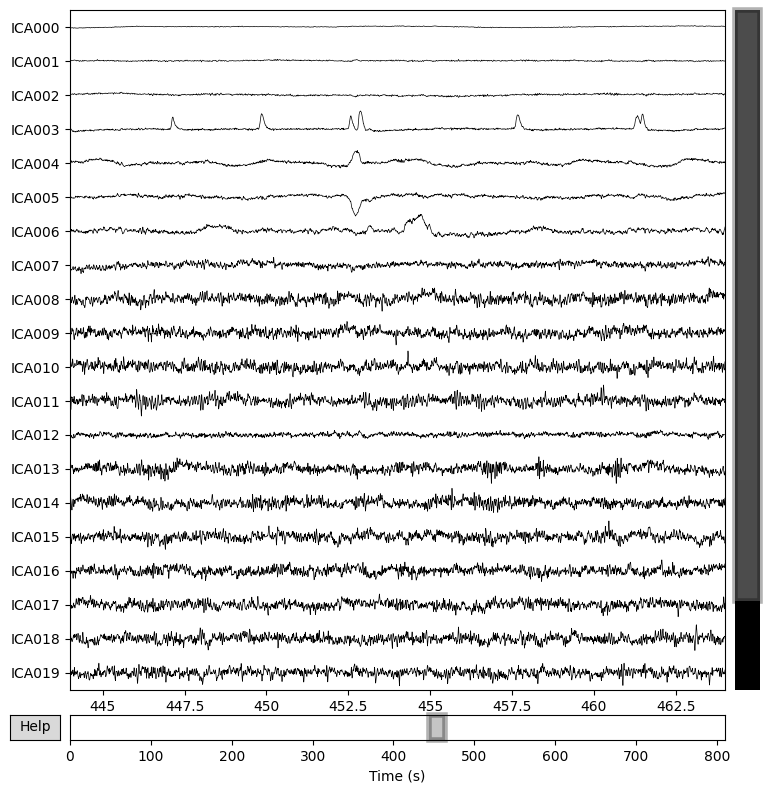

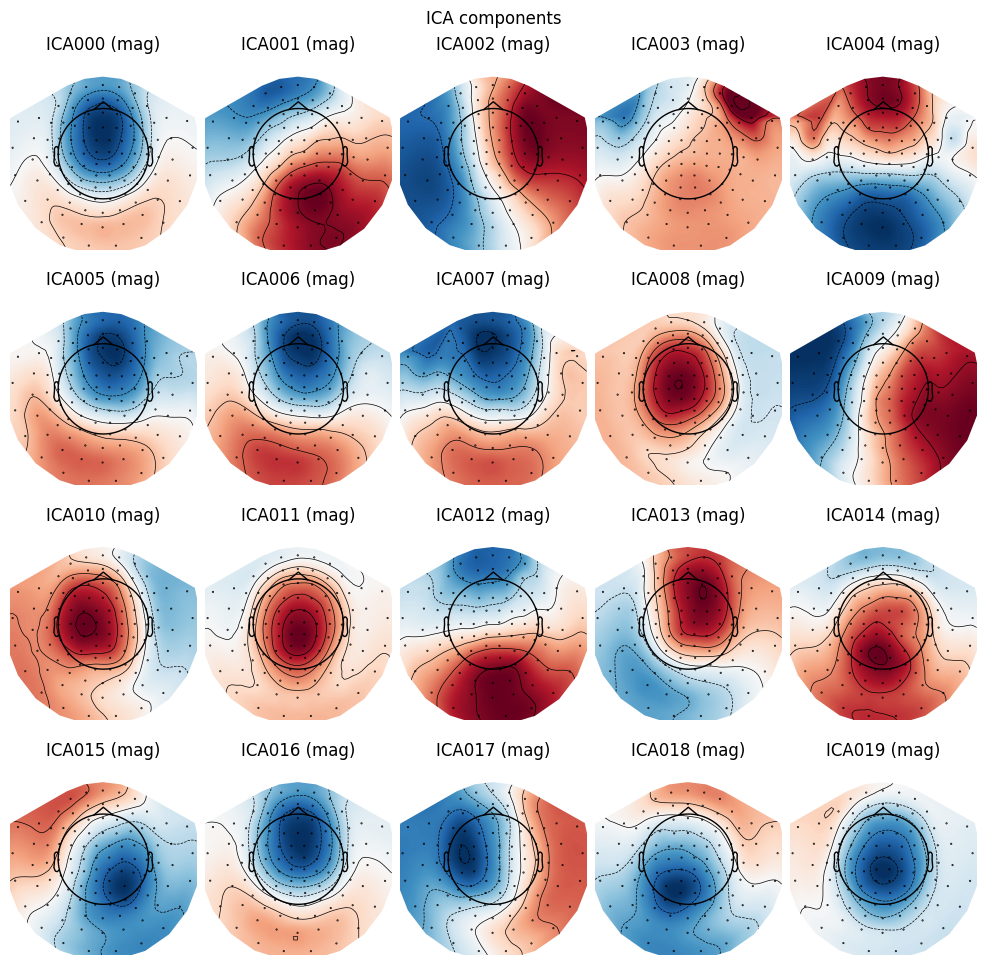

In [8]:
##Independent component analysis for preprocessing

raw.load_data()

orig_raw = raw.copy()
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)
ica.plot_sources(raw, start=444); #plotting time courses
ica.plot_components();

Creating RawArray with float64 data, n_channels=23, n_times=810000
    Range : 365000 ... 1174999 =    365.000 ...  1174.999 secs
Ready.


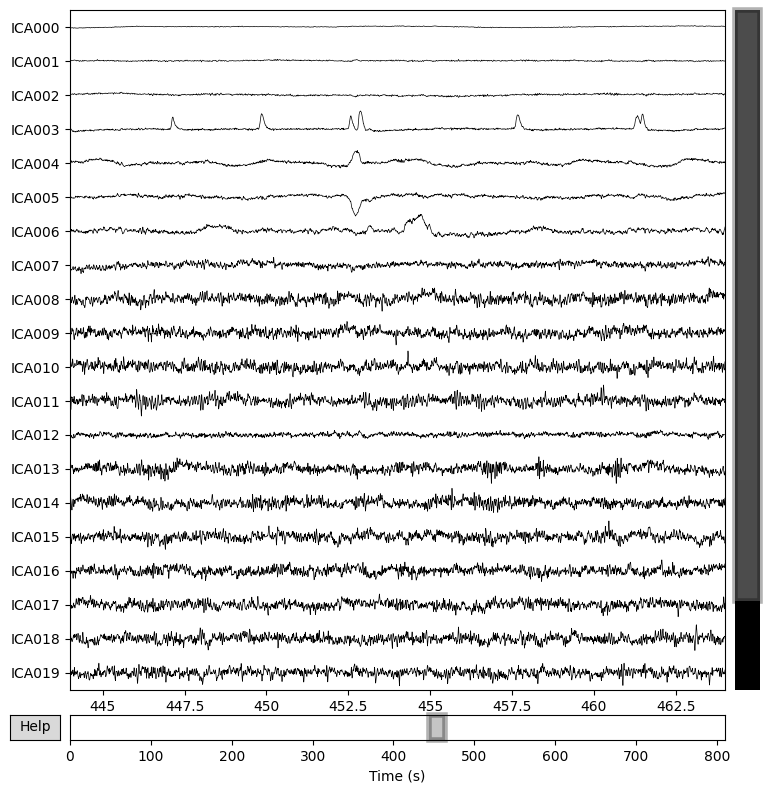

In [9]:
ica.plot_sources(raw, start=444); #plotting time courses

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
405 matching events found
No baseline correction applied
0 projection items activated


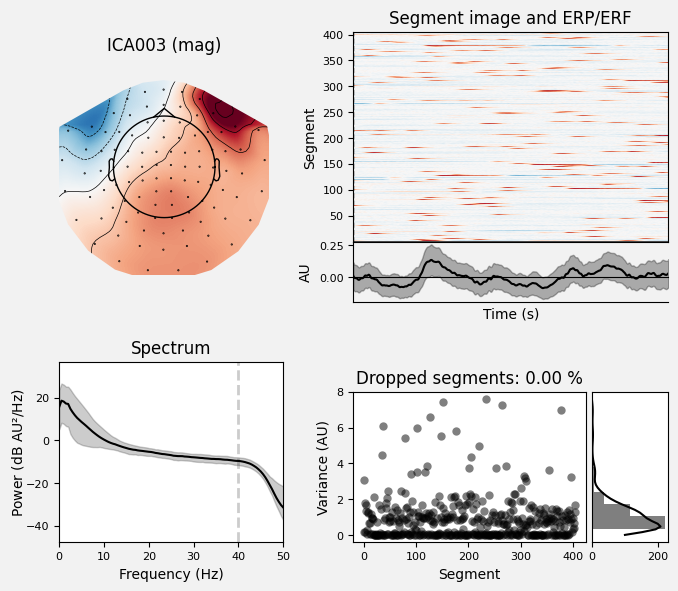

In [10]:
##Decide on components to exclude
ica.exclude=[3]
ica.plot_properties(raw, picks=ica.exclude);

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 306 PCA components


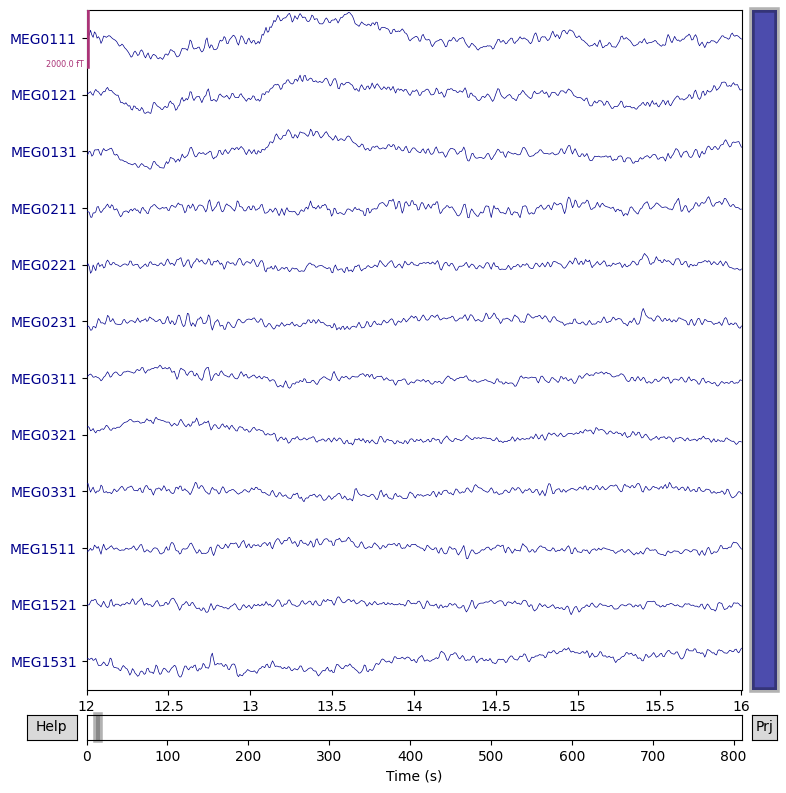

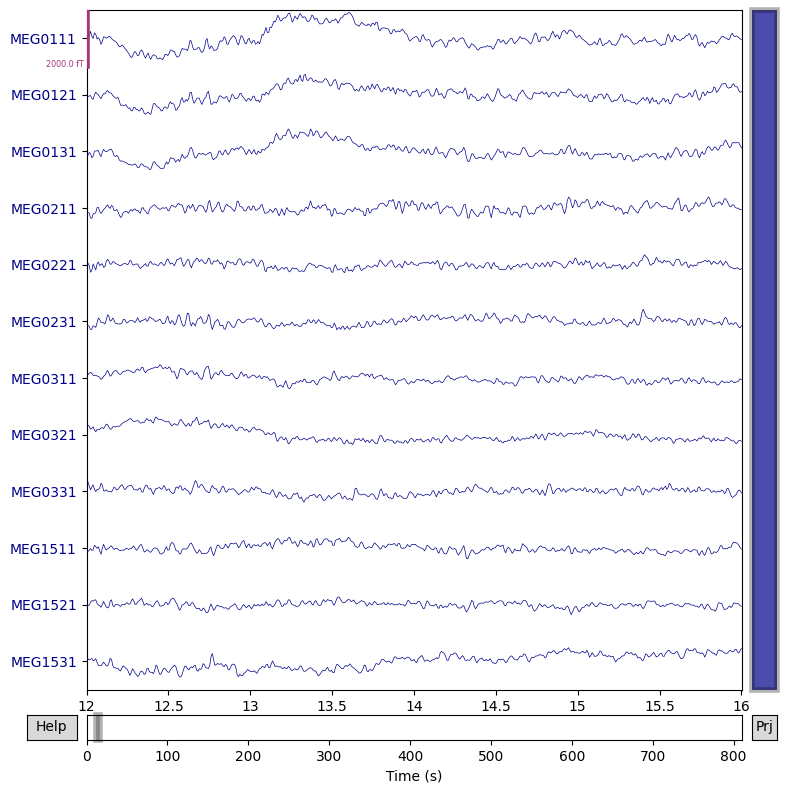

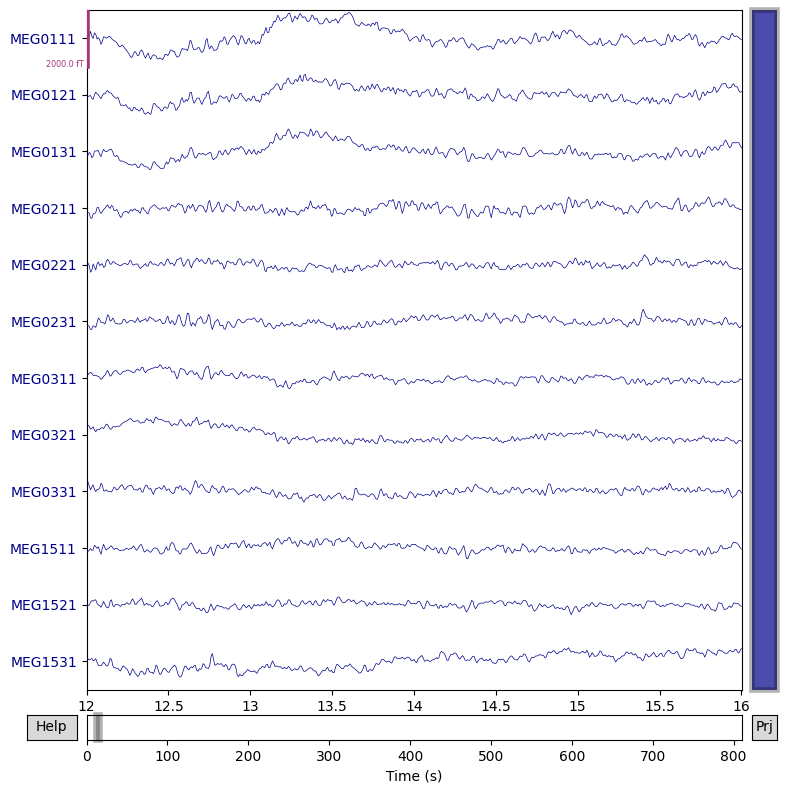

In [11]:
raw.load_data()
ica.apply(raw)

#show some frontal channels to clearly illustrate the artifact removal
chs = ['MEG0111', 'MEG0121', 'MEG0131', 'MEG0211', 'MEG0221', 'MEG0231',
       'MEG0311', 'MEG0321', 'MEG0331', 'MEG1511', 'MEG1521', 'MEG1531']
chan_idxs = [raw.ch_names.index(ch) for ch in chs]
orig_raw.plot(order=chan_idxs, start=12, duration=4)
raw.plot(order=chan_idxs, start=12, duration=4)


## Epoching

In [12]:
# %% FIND EVENTS

events = mne.find_events(raw, min_duration=0.002, consecutive=True)  ## returns a numpy array

# due to the online filtering of the MEG data, the square waves that constitute the trigger values 
# in the STI101-channel are sometimes not read very well during this process - and therefore we'll 
# only focus on those triggers that correspond to trigger values that we know are relevant
trigger_vals = [1,2,3,4,110,120,130,140,210,211,220,221,230,231,240,241]
true_events = events[np.isin(events[:,2], trigger_vals),:]

# unfortunately, the STI101-channel is really acting up in this dataset, and therefore multiple of the 
# relevant triggers are sometimes read as repeated values within a few milliseconds... gotta fix that too
# We identify for which rows the difference between two consecutive trigger values is 0 (i.e. they're identical 
# - cuz that shouldn't ever happen (check the event_id to (maybe) make sense of this)
repeat_idx = np.where(np.diff(true_events[:,2])==0)[0]
repeat_idx2 = repeat_idx+1 # we need the index of both the first and the second value in those pairs (it's only the second of the two that we delete)
repeat_combined = [[i, j] for i, j in zip(repeat_idx, repeat_idx2)] # we group indices in pairs for printing

# print to inspect if needed
#print(cropped_events[repeat_combined, 2])
#print(cropped_events[repeat_combined, :])

cropped_events = np.delete(true_events, repeat_idx2, axis=0)

1974 events found on stim channel STI101
Event IDs: [  1   2   3   4  11  12  13  14  15  16  17  19 110 120 126 130 134 140
 156 210 211 220 221 223 230 231 238 239 240 241 243 246 247 252 254 255]


1974
469


/tmp/ipykernel_224/2957343941.py:3: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(cropped_events, sfreq=raw.info["sfreq"]);  ## #%% SEGMENT DATA INTO EPOCHS


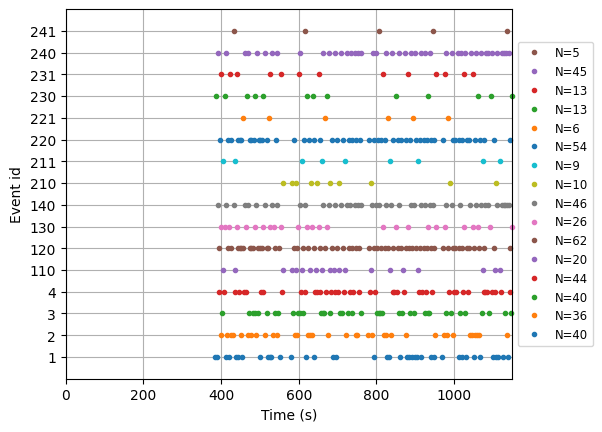

In [13]:
print(len(events))
print(len(cropped_events))
mne.viz.plot_events(cropped_events, sfreq=raw.info["sfreq"]);  ## #%% SEGMENT DATA INTO EPOCHS

In [14]:
# Do we have 160 deck-screens, deck-selection and win-/loss-screens?
print(len(cropped_events[cropped_events[:,2]<10,2]))
print(len(cropped_events[(cropped_events[:,2]>100) & (cropped_events[:,2]<150), 2]))
print(len(cropped_events[(cropped_events[:,2]>200) & (cropped_events[:,2]<250), 2]))

160
154
155


In [15]:
# Not quite... we might also wanna check whether the trigger values actually match the logfile-values 
# (given all the fuss about these trigger values)
# Let's bring in the logfiles then...

# loading in the logfiles
log_path = "/work/MEG_data/logfiles"
log_files = glob.glob(join(log_path, str(int(ID)) + sess + '*'))

df_load = []
for lf in np.sort(log_files):
    print(lf)
    df_load.append(pd.read_csv(join(log_path, lf)))
                        
df = pd.concat(df_load)

/work/MEG_data/logfiles/144A_sess_1 (2024-09-24 13-38-17).csv
/work/MEG_data/logfiles/144A_sess_2 (2024-09-24 13-41-30).csv
/work/MEG_data/logfiles/144A_sess_3 (2024-09-24 13-44-51).csv
/work/MEG_data/logfiles/144A_sess_4 (2024-09-24 13-48-01).csv


In [16]:
# cleaning the concatenated logfiles a bit

df_cropped = df.drop(['ID', 'dur_measured_decks', 'offset_decks', 'exp_type', 'offset_win'], axis=1) # throwing out columns with all NaN
df_cropped['deck_marked'] = df_cropped['init_mark'] + 1 # adjusting the indexing of "init_mark" to reflect actual deck-number rather than python index


In [17]:
# quick glance at the deck-screen-labels
df_cropped[['init_mark', 'deck_marked', 'deck_select', 'n_moves']]

init_mark  deck_marked  deck_select  n_moves
0           0            1            3        2
1           0            1            4        3
2           3            4            2        2
3           1            2            3        1
4           2            3            1        2
..        ...          ...          ...      ...
35          2            3            4        1
36          1            2            4        2
37          0            1            4        3
38          3            4            2        2
39          2            3            3        0

[160 rows x 4 columns]

In [18]:
# fixing the few deck-screen labels that were messed up due to the trigger values from button presses happening before the screen appearing
print(df_cropped[['deck_marked']].T.to_numpy()[0])
print(cropped_events[cropped_events[:,2]<10,2])

[1 1 4 2 3 4 1 2 1 2 2 4 1 1 4 2 1 4 4 2 3 2 3 3 2 3 1 4 4 2 3 1 1 1 2 3 2
 3 1 4 1 3 2 2 3 3 4 3 4 1 2 2 2 1 4 4 4 3 3 3 4 2 3 4 1 4 1 4 3 3 4 2 3 4
 3 4 2 2 4 3 2 4 2 1 4 3 3 3 3 2 2 1 1 2 4 4 4 3 1 3 4 2 1 1 3 1 3 1 1 4 1
 4 3 4 3 3 1 4 1 2 1 2 3 2 4 3 2 4 4 1 3 1 4 3 1 4 2 2 1 2 2 2 1 3 4 4 4 3
 4 1 4 1 1 4 1 3 2 1 4 3]
[1 1 4 2 3 4 1 2 1 2 2 4 1 1 4 2 1 4 4 2 3 2 3 3 2 3 1 4 4 2 3 1 1 1 2 3 2
 3 1 4 1 3 2 2 3 3 4 3 4 1 2 2 2 1 4 4 4 3 3 3 4 2 3 4 1 4 1 4 3 3 4 2 3 4
 3 4 2 2 4 3 2 4 2 1 4 3 3 3 3 2 2 1 1 2 4 4 4 3 1 3 4 2 1 1 3 1 3 1 1 4 1
 4 3 4 3 3 1 4 1 2 1 2 3 2 4 3 2 4 4 1 3 1 4 3 1 4 2 2 1 2 2 2 1 3 4 4 4 3
 4 1 4 1 1 4 1 3 2 1 4 3]


In [19]:
#This is the structure of interesting triggers / events
event_id = {'Visual/Deck/One': 1, # Decks presented, deck 1 marked
            'Visual/Deck/Two': 2, # Deck 2 marked
            'Visual/Deck/Three': 3, # Deck 3 marked
            'Visual/Deck/Four': 4, # Deck 4 marked
            'Visual/Win/One': 210, # Win screen, deck 1
            'Visual/Win/Two': 220, # Win screen, deck 2
            'Visual/Win/Three': 230, # Win screen, deck 3
            'Visual/Win/Four': 240, # Win screen, deck 4
            'Visual/Loss/One': 211, # Loss screen, deck 1
            'Visual/Loss/Two': 221, # Loss screen, deck 2
            'Visual/Loss/Three': 231, # Loss screen, deck 3
            'Visual/Loss/Four': 241, # Loss screen, deck 4
            'Response/Switch/First': 11, # y button press (switch), first
            'Response/Switch/Second': 12, # y button press, second
            'Response/Switch/Third': 13, # y button press, third
            'Response/Switch/Fourth': 14, # y button press, fourth
            'Response/Select/One': 110, # b button press (select), deck 1
            'Response/Select/Two': 120, # b button press, deck 2
            'Response/Select/Three': 130, # b button press, deck 3
            'Response/Select/Four': 140, # b button press, deck 4
              }  

In [20]:
#Segment the data into epochs
#Epochs can be rejected, if the signal exceeds the range that is expected. Read more here: https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs
# reject = dict(mag=4e-12, grad=4000e-13, eog=250e-6) # T, T/m, V   #You can try it out
reject = None    #Otherwise, all epochs are kept
#Create the epochs around the events. tmin is the time before the event, and tmax the time after the event.
epochs = mne.Epochs(
    raw,
    events,
    event_id,
    on_missing='warn',   #only report on missing events in data, but continue script
    tmin=-0.200,
    tmax=1.000,
    baseline=(None, 0),
    reject=reject,
    preload=True,
    proj=False,
)  ## have proj True, if you wanna reject

Not setting metadata
1167 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
Using data from preloaded Raw for 1167 events and 1201 original time points ...
0 bad epochs dropped


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


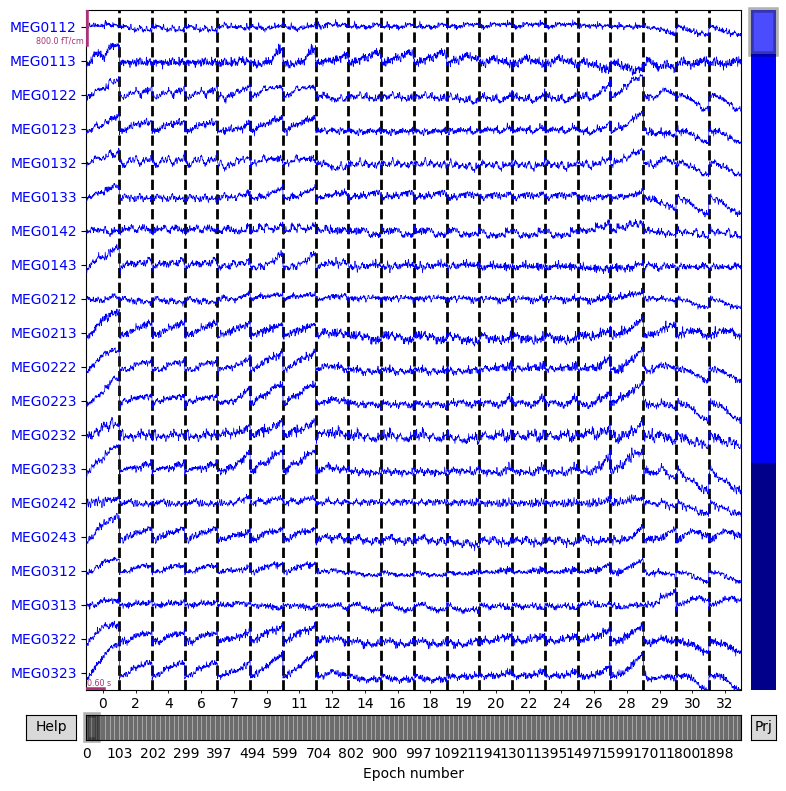

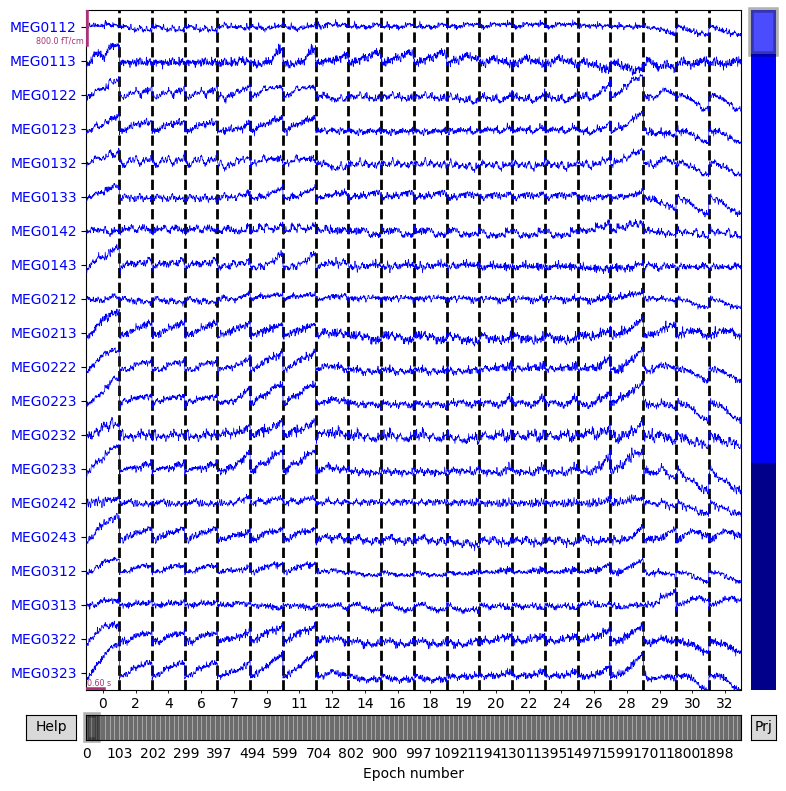

In [21]:
#Pick only MEG channels
epochs.pick_types(meg=True, eog=False, ias=False, emg=False, misc=False, stim=False, syst=False)

#show the epochs
epochs.plot()

In [22]:
# Characterizing epochs based on events
win_epochs = epochs['Win']
loss_epochs = epochs['Loss']
response_epochs = epochs['Response']
visual_epochs = epochs['Visual']
switch_epochs = epochs['Switch']

In [69]:
# %% EVOKED - AVERAGE - projections not applied

#Create evoked variables
win_evoked_responses = win_epochs.average()
loss_evoked_responses = loss_epochs.average()
response_evoked_responses = response_epochs.average()
visual_evoked_responses = visual_epochs.average()
switch_evoked_responses = switch_epochs.average()
all_evoked_responses = epochs.average()

Multiple channel types selected, returning one figure per type.
combining channels using RMS (mag channels)
combining channels using RMS (mag channels)


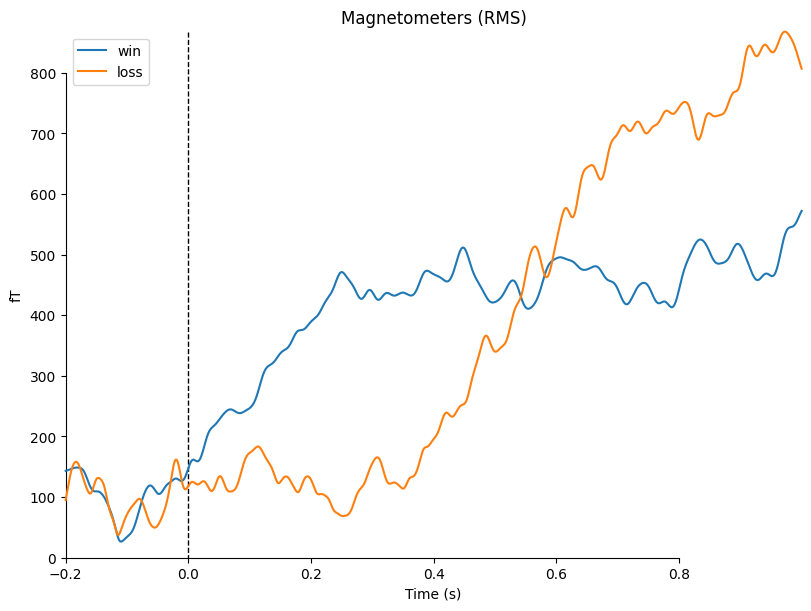

combining channels using RMS (grad channels)
combining channels using RMS (grad channels)


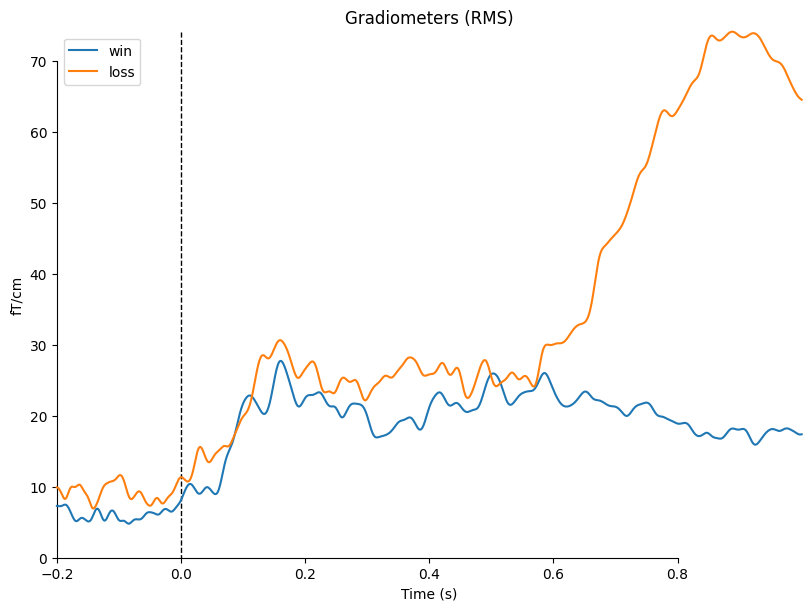

[<Figure size 800x600 with 1 Axes>, <Figure size 800x600 with 1 Axes>]

In [26]:
#Comparing groups
mne.viz.plot_compare_evokeds(dict(win = win_evoked_responses, loss = loss_evoked_responses))


## Source localization - Hypothesis 1

### Compute regularized noise covariance

In [28]:
noise_cov = mne.compute_covariance(
    epochs, tmax=0.0, method=("empirical", "shrunk"), return_estimators=True, rank=None
)

    Created an SSP operator (subspace dimension = 9)
    Setting small MEG eigenvalues to zero (without PCA)
Reducing data rank from 306 -> 297
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using SHRUNK
Done.
Using cross-validation to select the best estimator.
Number of samples used : 234567
log-likelihood on unseen data (descending order):
   shrunk: -1475.192
   empirical: -1475.206
[done]


Computing rank from covariance with rank=None
    Using tolerance 5.8e-15 (2.2e-16 eps * 102 dim * 0.26  max singular value)
    Estimated rank (mag): 96
    MAG: rank 96 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 1.6e-13 (2.2e-16 eps * 204 dim * 3.5  max singular value)
    Estimated rank (grad): 201
    GRAD: rank 201 computed from 204 data channels with 0 projectors


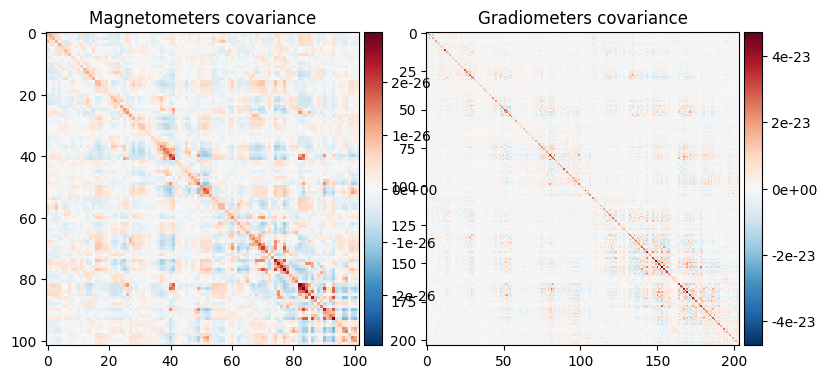

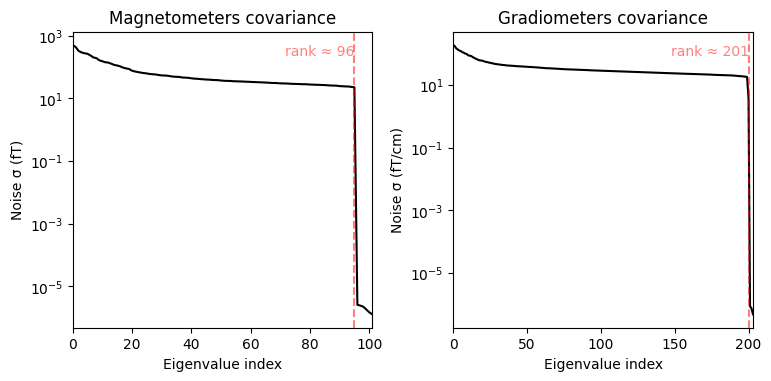

(<Figure size 760x370 with 4 Axes>, <Figure size 760x370 with 2 Axes>)

In [29]:
# Use the shrunk covariance for source localization
shrunk_cov = next(c for c in noise_cov if c['method'] == 'shrunk')

# Use the shrunk covariance matrix in your analysis
mne.viz.plot_cov(shrunk_cov, epochs.info)


In [30]:
# %% SOURCE RECONSTRUCTION 

bem_path = "/work/freesurfer/" + "0144/bem"    
subjects_dir = "/work/freesurfer/"    #path to all subjects
fwd_name = "0144-sessA-src-fwd.fif"  
subject = '0144'

# read forward solution
fwd = mne.read_forward_solution(join(bem_path, fwd_name))
src = fwd["src"]  # where are the sources
trans = fwd["mri_head_t"]  # what's the transformation between mri and head space
info = epochs.info  # where are the sensors?
bem_sol = fwd["sol"]  # how do electric fields spread from the sources inside the head?


Reading forward solution from /work/freesurfer/0144/bem/0144-sessA-src-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (8196 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


In [31]:
from mne.minimum_norm import apply_inverse, read_inverse_operator

# %% operator that specifies how noise cov should be applied to the fwd
inverse_operator = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, shrunk_cov)

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 7685/8196 = 10.000525
    scale = 4.99698e-08 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 9)
Computing rank from covariance with rank=None
    Using tolerance 2.5e-13 (2.2e-16 eps * 306 dim * 3.7  max singular value)
    Estimated rank (mag + grad): 297
    MEG: rank 297 computed from 306 data channels with 9 projectors
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and 

In [79]:
labels_vol = [
    "Left-Accumbens-area",
    "Right-Accumbens-area",
]

mri_path = "/work/freesurfer/" + "0144/mri"
fname_aseg = mri_path + "/aseg.mgz"


vol_src = mne.setup_volume_source_space(
    subject=subject,
    mri=fname_aseg,
    pos=5.0,
    bem=bem_path + '/0144-bem-sol.fif',
    volume_label=labels_vol,
    subjects_dir=subjects_dir,
    add_interpolator=False,  # just for speed, usually this should be True
    verbose=True,
)

# Generate the mixed source space
src += vol_src
print(
    f"The source space contains {len(src)} spaces and "
    f"{sum(s['nuse'] for s in src)} vertices"
)

BEM              : /work/freesurfer/0144/bem/0144-bem-sol.fif
grid                  : 5.0 mm
mindist               : 5.0 mm
MRI volume            : /work/freesurfer/0144/mri/aseg.mgz

Reading /work/freesurfer/0144/mri/aseg.mgz...

Loaded inner skull from /work/freesurfer/0144/bem/0144-bem-sol.fif (2562 nodes)
Surface CM = (  -0.1  -17.1   33.6) mm
Surface fits inside a sphere with radius   99.0 mm
Surface extent:
    x =  -68.1 ...   67.5 mm
    y = -100.7 ...   81.4 mm
    z =  -46.9 ...  104.9 mm
Grid extent:
    x =  -70.0 ...   70.0 mm
    y = -105.0 ...   85.0 mm
    z =  -50.0 ...  105.0 mm
36192 sources before omitting any.
27371 sources after omitting infeasible sources not within 0.0 - 99.0 mm.
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 27371 points...
    Found  5188/27371 points inside  an interior sphere of radius   53.7 mm
    Found     0/27371 

In [80]:
for label in ["Left-Accumbens-area", "Right-Accumbens-area"]:
    vertices = [src['nuse'] for src in vol_src if src['seg_name'] == label]
    print(f"{label}: {vertices} vertices")


Left-Accumbens-area: [2] vertices
Right-Accumbens-area: [5] vertices


In [81]:
## forward model as a volume

path_trans = join(bem_path, '0144-trans.fif')
output_name = bem_path + '\0144-sessA-src-fwd_vol.fif'

info = mne.io.read_info(fname)
trans = path_trans   
bem = join(bem_path, '0144-bem-sol.fif')            

fwd_vol = mne.make_forward_solution(info, trans, vol_src, bem)

    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
Source space          : <SourceSpaces: [<volume (Left-Accumbens-area), n_used=2>, <volume (Right-Accumbens-area), n_used=5>] MRI (surface RAS) coords, subject '0144', ~16.1 MB>
MRI -> head transform : /work/freesurfer/0144/bem/0144-trans.fif
Measurement data      : instance of Info
Conductor model   : /work/freesurfer/0144/bem/0144-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a tot

In [82]:
#inverse model
inverse_operator_vol = mne.minimum_norm.make_inverse_operator(info, fwd_vol, shrunk_cov)

Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 8/7 = 1.286006
    scale = 3.88917e-08 exp = 0.8
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 9)
Computing rank from covariance with rank=None
    Using tolerance 2.5e-13 (2.2e-16 eps * 306 dim * 3.7  max singular value)
    Estimated rank (mag + grad): 297
    MEG: rank 297 computed from 306 data channels with 9 projectors
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 16.2988
    scaling factor to adjust the trace = 4.10968e+16 (nchan = 306 nzero = 9)


In [83]:
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img

snr = 3.0
lambda2 = 1.0 / snr ** 2
method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)

#inverse_operator = read_inverse_operator(fname_inv)
src_vol = inverse_operator_vol['src']

# Compute inverse solution
stc_vol_win = mne.minimum_norm.apply_inverse(win_evoked_responses, inverse_operator_vol, lambda2, method)
#stc.crop(0.0, 0.2)


Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 163
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 9)
    Created the whitener using a noise covariance matrix with rank 297 (9 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "0.09 × Visual/Win/One + 0.51 × Visual/Win/Two + 0.12 × Visual/Win/Three + 0.28 × Visual/Win/Four"...
    Picked 306 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained   8.4% variance
    Combining the current components...
    dSPM...
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1167
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 9)
    Created the whitener using a noise covariance matrix with rank 297 (9 small eigenvalues o

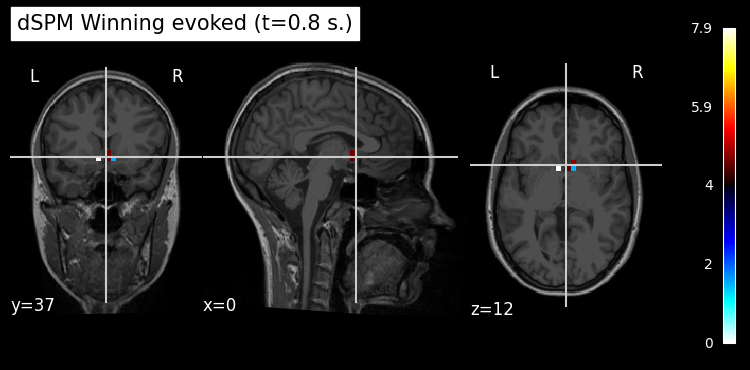

In [96]:
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img
import nibabel as nib


# Export result as a 4D nifti object
# Convert source estimates to NIfTI
img_win = stc_vol_win.as_volume(src_vol, mri_resolution=False)  # src_vol is the source space
# Save the NIfTI files
win_file = 'winning_condition_activation.nii.gz'
nib.save(img_win, win_file)


t1_fname = join(mri_path, 'T1.mgz')

# Plot for winning epochs
plot_stat_map(index_img(img_win, 1000), t1_fname, threshold=0,  # Use the anatomical T1 file as bg_img
              title='%s Winning evoked (t=%.1f s.)' % (method, stc_vol_win.times[1000]))

plt.show()


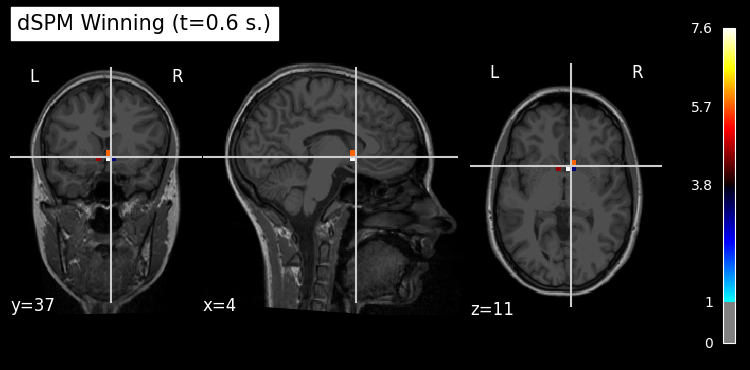

In [99]:
# Plot for winning epochs
plot_stat_map(index_img(img_win, 800), t1_fname, threshold=1.,  # Use the anatomical T1 file as bg_img
              title='%s Winning (t=%.1f s.)' % (method, stc_vol_win.times[800]))

plt.show()

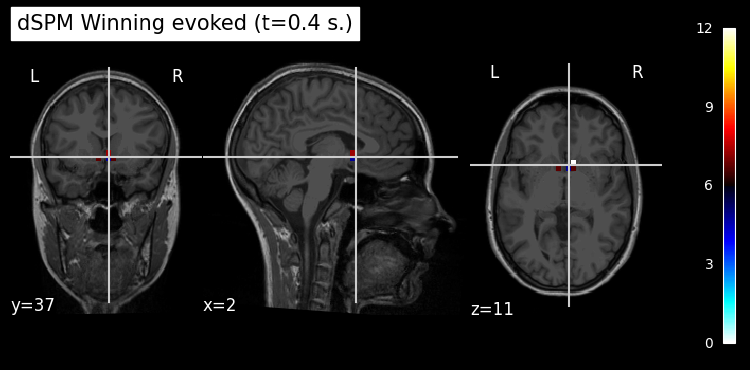

In [97]:
plot_stat_map(index_img(img_win, 600), t1_fname, threshold=0,  # Use the anatomical T1 file as bg_img
              title='%s Winning evoked (t=%.1f s.)' % (method, stc_vol_win.times[600]))
plt.show()

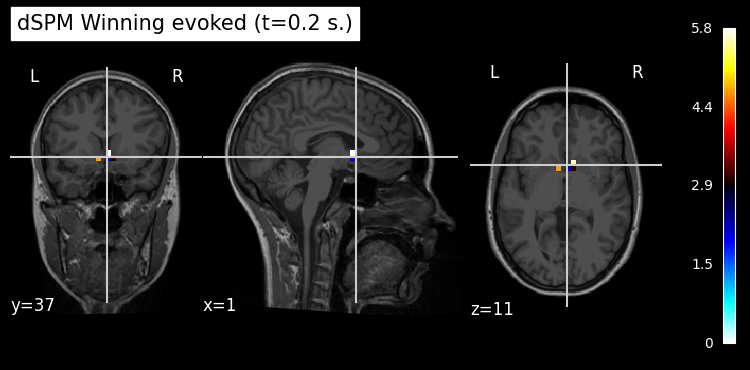

In [98]:
plot_stat_map(index_img(img_win, 400), t1_fname, threshold=0,  # Use the anatomical T1 file as bg_img
              title='%s Winning evoked (t=%.1f s.)' % (method, stc_vol_win.times[400]))
plt.show()